# NeRF Rendering Testing

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataset import get_rays
from rendering import rendering

In [2]:
device = 'cuda'
tn = 8.
tf = 12.

In [3]:
test_o, test_d, test_target_px_values = get_rays('datasets/monkey_3', mode='test')
model = torch.load('nerf_models/monkey_biz.pth').to(device)

In [4]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

## Render any test image from the dataset

41.68119994945638


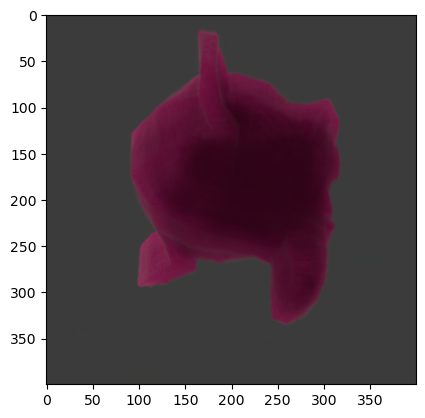

In [7]:
test_img_idx = 0

img, mse, psnr = test(model, torch.from_numpy(test_o[test_img_idx]).to(device).float(), torch.from_numpy(test_d[test_img_idx]).to(device).float(),
                tn, tf, nb_bins=100, chunk_size=10, target=test_target_px_values[test_img_idx].reshape(400, 400, 3))

print(psnr)
plt.imshow(img);